In [1]:
pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [2]:
import pandas as pd
from google.colab import files
upload = files.upload()


Saving df_consensus.csv to df_consensus.csv


In [3]:
!pip install transformers torch


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [5]:
df = pd.read_csv('df_consensus.csv')
df.head()

,Title,Frame Code Mode
0,!Bienvenidos!; As more Hispanic immigrants mov...,11.1
1,"""BLACK HAWK DOWN""; THE MOVIE; SOMALIS IN TWIN ...",11.1
2,"""THE IMMIGRANT"" BLENDS STORY, DIALOGUE, CHARAC...",11.1
3,"""The economic gears of this country are depend...",1.1
4,"""We need new laws; we have to speak out; we ha...",4.1


In [6]:
df = df.dropna(subset=['Frame Code Mode'])

In [7]:
df = df.dropna(subset=['Title'])

In [8]:
len(df['Frame Code Mode'].unique())

15

In [9]:
# Shift labels to range from 0 to 14
df['Frame Code Mode'] = df['Frame Code Mode'] - 1


In [17]:
df['Frame Code Mode'].unique()

array([10,  0,  3,  5,  7,  6,  9, 11,  4,  1, 12,  2, 14,  8, 13])

In [11]:
import pandas as pd
# Convert column values to integers
df['Frame Code Mode'] = df['Frame Code Mode'].astype(int)

headlines = df['Title'].tolist()
frames = df['Frame Code Mode'].tolist()


In [12]:
class NewsDataset(Dataset):
    def __init__(self, headlines, frames, tokenizer, max_length):
        self.headlines = headlines
        self.frames = frames
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        text = self.headlines[idx]
        label = self.frames[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=15)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, labels):
        ce_loss = nn.CrossEntropyLoss()(logits, labels)
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss


In [15]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(headlines, frames, test_size=0.2, random_state=42)

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


In [18]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,

)

# Custom model with Focal Loss
class CustomBERTModel(nn.Module):
    def __init__(self, model, num_labels, focal_loss):
        super(CustomBERTModel, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.focal_loss = focal_loss

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = self.focal_loss(logits, labels)
        return SequenceClassifierOutput(loss=loss, logits=logits)

focal_loss = FocalLoss(alpha=0.25, gamma=2)  # Adjust alpha for class imbalance
custom_model = CustomBERTModel(model, num_labels=15, focal_loss=focal_loss)

trainer = Trainer(
    model=custom_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.445000,0.262814
2,0.174800,0.231557
3,0.071900,0.250918
4,0.024800,0.265738
5,0.011700,0.297226
6,0.003800,0.314084
7,0.001500,0.324523
8,0.001600,0.326018
9,0.000600,0.328414
10,0.000400,0.327768


TrainOutput(global_step=9690, training_loss=0.06729715013582456, metrics={'train_runtime': 508.8379, 'train_samples_per_second': 76.115, 'train_steps_per_second': 19.043, 'total_flos': 0.0, 'train_loss': 0.06729715013582456, 'epoch': 10.0})

In [19]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.3277684152126312, 'eval_runtime': 3.1054, 'eval_samples_per_second': 312.035, 'eval_steps_per_second': 78.25, 'epoch': 10.0}


Micro Accuracy: 0.5851
Confusion Matrix:
[[ 46   5   0   1   7   6   3   0   0   4   1   2   0   0   0]
 [  3  29   0   0   6   6   3   0   0   1   6   1   0   0   4]
 [  2   0   5   0   2   0   0   0   0   0   1   0   1   0   1]
 [  1   0   0  11   3   4   1   0   1   0   0   0   4   0   1]
 [  3   7   0   3 138  18  18   1   2   3   1   1   5   1   6]
 [  2   4   0   0  13  39   7   5   1   1   0   2   6   1   3]
 [  5   0   0   1  14   1 104   2   4   1   0   1   3   0   1]
 [  0   1   1   0   1   4   3  15   0   2   0   0   1   0   1]
 [  1   1   1   1   4   0   3   0  12   2   1   1   0   0   2]
 [  4   1   0   0   1   3   2   0   3  21   5   3   0   0   6]
 [  2   0   1   2   0   5   1   0   0   7  41   5   2   1   6]
 [  0   1   1   1   0   4   0   0   0   0   3  17   5   0   3]
 [  2   0   0   1   5  18   4   2   0   0   2   1  61   4   3]
 [  0   0   0   0   0   0   2   1   0   1   0   1   0  13   0]
 [  0   0   0   1   4   4   4   1   0   2   0   0   2   0  15]]


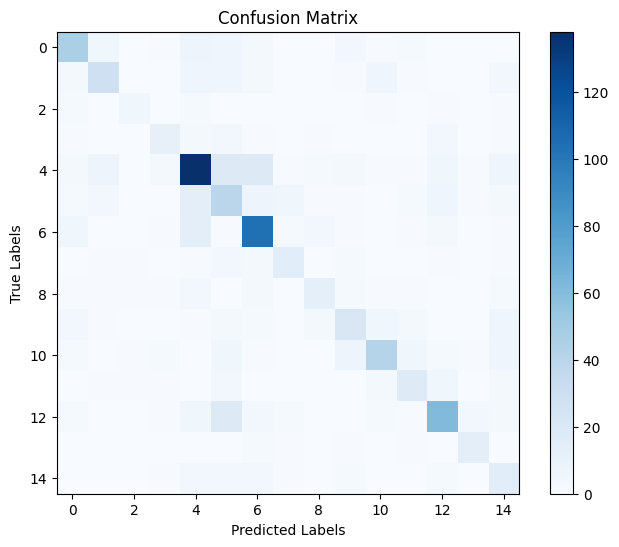

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation dataset
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)  # Get the predicted class labels
labels = predictions.label_ids                    # True labels

# Calculate micro accuracy
micro_accuracy = accuracy_score(labels, preds)
print(f"Micro Accuracy: {micro_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(labels, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [24]:
misclassified_indices = np.where(labels != preds)[0]

# Display up to 20 misclassified titles using indices
print("Misclassified Titles (up to 20):")
for i in misclassified_indices[:20]:
    title = val_texts[i]  # Retrieve the title using the index
    true_label = val_labels[i]
    predicted_label = preds[i]
    print(f"Title: {title}\nTrue Label: {true_label}, Predicted Label: {predicted_label}\n")

Misclassified Titles (up to 20):
Title: Workers In the Shadows
True Label: 9, Predicted Label: 0

Title: WOMEN OF VALOR TRIO FIGHTS LENDERS WHO PREY ON THE UNDOCUMENTED
True Label: 2, Predicted Label: 0

Title: Get Real on Illegal Immigration
True Label: 3, Predicted Label: 12

Title: THREATS AND RESPONSES: THE JUSTICE DEPARTMENT; Ashcroft Seeks More Power To Pursue Terror Suspects
True Label: 4, Predicted Label: 7

Title: INACTION ON IMMIGRATION TOUCHES OFF FREE-FOR-ALL
True Label: 12, Predicted Label: 5

Title: FOREIGN STUDENTS BACK VISA SECURITY SOME COLLEGE OFFICIALS FEAR PLANS MAY DETER APPLICANTS
True Label: 11, Predicted Label: 1

Title: Illegal immigrant driver's licenses endorsed; 2 metro police chiefs support bill
True Label: 9, Predicted Label: 11

Title: CITY CAME TOGETHER TO HELP NEW N.Y.ERS
True Label: 10, Predicted Label: 5

Title: America forced to work at diversity
True Label: 10, Predicted Label: 3

Title: INS lacks funds for fight Sanctions unlikely for resorts
True 

In [25]:
import numpy as np

# Calculate misclassification counts for each class (sum of off-diagonal cells per row)
misclassification_counts = []
for i in range(conf_matrix.shape[0]):
    misclassifications = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    misclassification_counts.append((i, misclassifications))

# Sort classes by misclassification counts in descending order
top_misclassified_classes = sorted(misclassification_counts, key=lambda x: x[1], reverse=True)

# Display the top 5 misclassified classes
print("Top misclassified classes and their misclassification counts:")
for i in range(min(5, len(top_misclassified_classes))):
    class_idx, count = top_misclassified_classes[i]
    print(f"Class {class_idx} - Misclassified {count} times")

    # Display which classes it's misclassified into the most
    most_confused_with = np.argsort(conf_matrix[class_idx, :])[-3:]  # Top 3 most confused classes
    print(f"  Commonly misclassified as: {most_confused_with.tolist()}")


Top misclassified classes and their misclassification counts:
Class 4 - Misclassified 69 times
  Commonly misclassified as: [5, 6, 4]
Class 5 - Misclassified 45 times
  Commonly misclassified as: [6, 4, 5]
Class 12 - Misclassified 42 times
  Commonly misclassified as: [4, 5, 12]
Class 6 - Misclassified 33 times
  Commonly misclassified as: [0, 4, 6]
Class 10 - Misclassified 32 times
  Commonly misclassified as: [14, 9, 10]
